In [16]:
%matplotlib inline

from __future__ import division
import numpy as np
import menpo.io as mio
from menpo.image import Image
from menpo.feature import ndfeature, greyscale, centralize
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images, print_dynamic, progress_bar_str
from menpofit.visualize import visualize_fitting_results
from alaborticcv2015.alignment import LKFitter, FilteredSSD, FilteredFourierSSD

In [17]:
@ndfeature
def grey_igo(pixels):
    pixels = greyscale(pixels)
    pixels = igo (pixels)
    return pixels

def greyscale_average(pixels):
    return greyscale(pixels, mode='average')

# Multipie experiment: SVM Net tunning

Load training data:

In [18]:
folder_path = '/data/PhD/alaborticcv2015/'

In [19]:
images = []
for i in mio.import_images(folder_path + 'data/multipie/002/', verbose=True):
    i.crop_to_landmarks_proportion_inplace(0.5)
    i = i.rescale_landmarks_to_diagonal_range(200)
    labeller(i, 'PTS', ibug_face_66)
    lms = i.landmarks['ibug_face_66'].lms
    bb = lms.bounding_box()
    i.landmarks['bounding_box'] = bb
    images.append(i)

- Loading 20 assets: [====================] 100%

In [20]:
template = images[7]
test_images = images

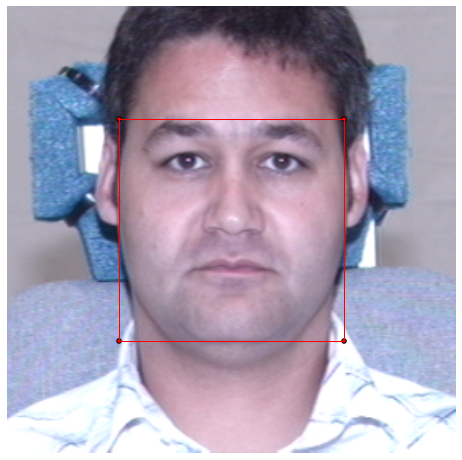

In [21]:
visualize_images(template)

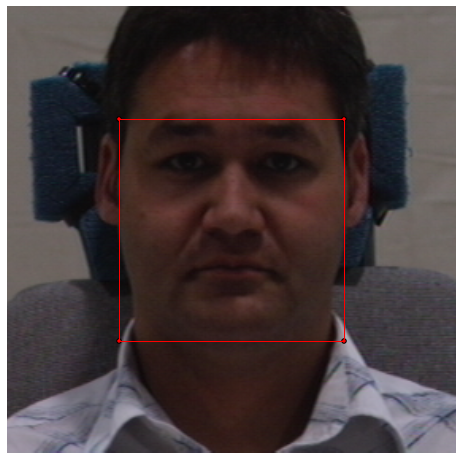

In [22]:
visualize_images(test_images)

Define network parameters:

In [30]:
features = greyscale_average
architecture = 1
normalize_patches = centralize
normalize_filters = None

patch_shape = [ps for ps in range(2, 11, 1)]

Define fitter parameters:

In [31]:
diagonal = 100
scales = (1,)
max_iters = 50
noise_std = 10
n_rep = 3

Align:

In [32]:
count = 0
results = []
errors = np.empty((len(patch_shape), len(images), n_rep, max_iters+len(scales)))

# for all networks
for m, ps in enumerate(patch_shape):

    string = '- network {}, {}: '.format(ps, count)

    file_name = (folder_path
                 + 'networks/svm_net/svm_net_'
                 + features.__name__ + '_'
                 + str(1) + '_' 
                 + str(architecture) + '_'
                 + str(ps) + '.pkl.gz') 
    net = mio.import_pickle(file_name)

    # define kernel function
    def kernel_func(ext_shape):
        return net._compute_kernel(ext_shape=ext_shape)

    # create LK fitter
    fitter = LKFitter(template,
                      group='bounding_box',
                      features=features,
                      diagonal=diagonal,
                      scales=scales,
                      residual_cls=FilteredFourierSSD,
                      kernel_func = kernel_func,
                      eps=-1)

    # random seed
    np.random.seed(seed=0)

    # for all images
    fitter_results = []
    for j, i in enumerate(test_images):
        string2 = string + ' image {}: '.format(j)

        # for each repetition
        frs = []
        for k in range(n_rep):

            # fit image
            gt_s = i.landmarks['bounding_box'].lms
            s = fitter.perturb_shape(gt_s, noise_std=noise_std)
            fr = fitter.fit(i, s, gt_shape=gt_s, max_iters=max_iters)

            # save fitter result
            fr = fr.as_serializableresult()
            frs.append(fr)

            # compute error
            errors[m, j, k] = fr.errors() 

        # save each repetition fitting result
        fitter_results.append(frs)

        # compute and print errors statistics per image
        ini_errors = errors[m, j, :, 0]
        ini_mean = np.mean(ini_errors)
        ini_median = np.median(ini_errors)
        ini_std = np.std(ini_errors)
        final_errors = errors[m, j, :, -1]
        final_mean = np.mean(final_errors)
        final_median = np.median(final_errors)
        final_std = np.std(final_errors)
        print_dynamic(string2 + 
                      '\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                      ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                      ' std: {0:.4f} - {1:.4f} '.format(ini_std, final_std))

    # compute and print error statistics per network
    ini_errors = errors[m, :, :, 0]
    ini_mean = np.mean(ini_errors)
    ini_median = np.median(ini_errors)
    ini_std = np.std(ini_errors)
    final_errors = errors[m, :, :, -1]
    final_mean = np.mean(final_errors)
    final_median = np.median(final_errors)
    final_std = np.std(final_errors)
    print_dynamic(string + 
                  '\t\tmean: {0:.4f} - {1:.4f} '.format(ini_mean, final_mean) +
                  ' median: {0:.4f} - {1:.4f} '.format(ini_median, final_median) +
                  ' std: {0:.4f} - {1:.4f} \n'.format(ini_std, final_std))

    # save network fitting results
    file_name = (folder_path
                 + 'results/multipie/tunning/multipie_svm_dck_' 
                 + features.__name__ + '_'
                 + str(1) + '_' 
                 + str(architecture) + '_'
                 + str(ps) + '_'
                 + 'tunning.pkl.gz') 
    mio.export_pickle(fitter_results, file_name, overwrite=True)

    # save each image fitting result
    results.append(fitter_results)

    count += 1

- network 2, 0: 		mean: 0.0770 - 0.0548  median: 0.0781 - 0.0344  std: 0.0212 - 0.0580 
- network 3, 1: 		mean: 0.0770 - 0.0488  median: 0.0781 - 0.0071  std: 0.0212 - 0.0607 
- network 4, 2: 		mean: 0.0770 - 0.0418  median: 0.0781 - 0.0069  std: 0.0212 - 0.0561 
- network 5, 3: 		mean: 0.0770 - 0.0403  median: 0.0781 - 0.0086  std: 0.0212 - 0.0589 
- network 6, 4: 		mean: 0.0770 - 0.0359  median: 0.0781 - 0.0091  std: 0.0212 - 0.0519 
- network 7, 5: 		mean: 0.0770 - 0.0367  median: 0.0781 - 0.0106  std: 0.0212 - 0.0529 
- network 8, 6: 		mean: 0.0770 - 0.0358  median: 0.0781 - 0.0112  std: 0.0212 - 0.0535 
- network 9, 7: 		mean: 0.0770 - 0.0406  median: 0.0781 - 0.0123  std: 0.0212 - 0.0564 
- network 10, 8: 		mean: 0.0770 - 0.0403  median: 0.0781 - 0.0127  std: 0.0212 - 0.0565 


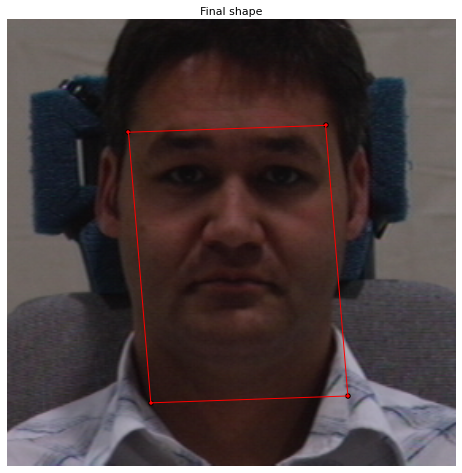

In [33]:
# undo list nesting
fitter_results = [fr for frs in results[4] for fr in frs]

# visualize
visualize_fitting_results(fitter_results)